## Hecho Por: Juan Felipe Camelo, Silvana Sandoval, Adrián Suárez

### Importación de las librerías a usar

In [1]:
import pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Ejercicio 1

La solución propuesta se realiza con pyomo. Como variables teneoms los nodos del grafo, como parámetros tenemos la función de costos que conectan los nodos del grafo y el valor inicial del e-constraint; se puso el ejemplo del laboratorio. Posteriormente definimos un valor muy alto para asignar a las conexiones que no existen entre nodos, esto dado que neusta variable de decisión es binaria y requiere que existan las conexiones para poder correr el programa. 

Posteriormente creamos una lista donde guardaremos las tuplas (e-constraint, costo), que representan el valor de e-constraint, el cual indica la cantidad de saltos, y el costo total. El modelo busca minimizar la función de costo usando la función de saltos como una restricción, a la cuál se le aplica el e-constraint. Nuestra variable de decisión binaria nos indica aquellas conexiones que si vamos a tomar, y así minimizamos el costo. Las primeras 3 restricciones son las básicas para un grafo de flujo, estableciendo un nodo inicial, un nodo final, y que el flujo que sale es igual al que entra. Finalmente se agrega la función de "hops" como una restricción adicional, donde decimos que la cantidad de nodos recorridos entre el nodo de inicio y el final debe ser menor o igual al valor de e-constraint. 

Entrando en detalles técnicos, para iterar sobre los valores de e-constraint se usa un loop con while, y si al final se resuelve un modelo factible, se agrega la solución a la lista de resultados. Un modelo factible sería aquel cuyo costo sea igual al valor que inicialmente definimos como "muy alto" para conexiones inexistentes. En el ejemplo del enunciado, no existe forma de resolver el problema con 1 salto, pero en nuestro modelo si lo resolvería, con un costo de 10000, por lo cual se define que itere hasta que el valor del costo sea infactible. Para la impresión se invierte la tabla de resultados, puesto que el valor de e-constraint va disminuyendo, es decir, con 5 saltos máximos da el mismo resultado hasta 3, por lo cual el punto del óptimo de Pareto es 3 saltos, así que tomamos los valores al revés y aquellos que repitan costo solo los ignoramos. Finalmente se grafican los puntos que son óptimos de Pareto. 

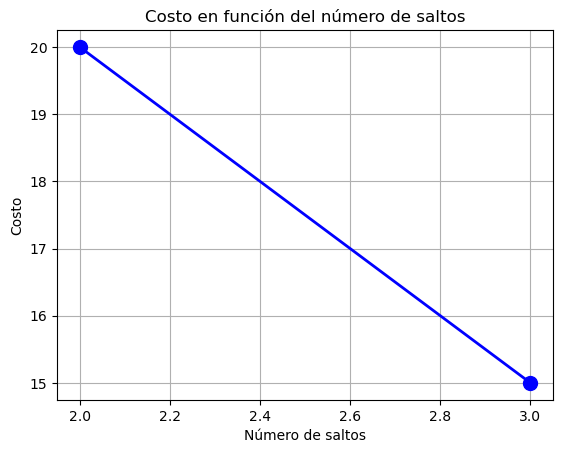

In [2]:

# Variables
nodos = ["n1", "n2", "n3", "n4", "n5"]


# Parámetros
costos = {"n1": {"n2": 10, "n3": 5},
          "n2": {"n5": 10},
          "n3": {"n4": 5},
          "n4": {"n5": 5}}
e_constraint = 5

# Asignar un costo muy alto a las conexiones inexistentes
costo_alto = 10000
for i in nodos:
    if i not in costos:
        costos[i] = {}
    for j in nodos:
        if j not in costos[i]:
            costos[i][j] = costo_alto

resultados = []
# Resolver para cada valor de e

while e_constraint > 0:

    # Crear el modelo
    model = ConcreteModel()

    # Variable de decisión
    model.x = Var(nodos, nodos, domain=Binary)

    # Función objetivo
    def objetivo(model):
        return sum(costos[i][j] * model.x[i, j] for i in nodos for j in nodos)
    model.objetivo = Objective(rule=objetivo, sense=minimize)

    ### Restricciones
    # Restricción para el nodo fuente
    def regla_fuente(model):
        return sum(model.x["n1", j] for j in nodos) == 1
    model.fuente = Constraint(rule=regla_fuente)

    # Restricción para el nodo destino
    def regla_destino(model):
        return sum(model.x[j, "n5"] for j in nodos) == 1
    model.destino = Constraint(rule=regla_destino)

    # Restricción para los nodos intermedios
    def regla_inter(model, i):
        if i not in ["n1", "n5"]:
            return sum(model.x[i, j] for j in nodos) - sum(model.x[j, i] for j in nodos) == 0
        else:
            return Constraint.Skip
    model.intermedio = Constraint(nodos, rule=regla_inter)

    # Restricción de salto
    def regla_hops(model):
        return sum(model.x[i, j] for i in nodos for j in nodos) <= e_constraint
    model.hops = Constraint(rule=regla_hops)

    #Resolver e
    solver = SolverFactory('glpk')
    solver.solve(model)
    #model.display()
    
    costo = value(model.objetivo)
    if costo < costo_alto:
        if (int, costo) not in resultados:
            resultados.append((e_constraint, costo))
            e_constraint -= 1
    else: break

# Recorrer los resultados al revés y eliminar duplicados
resultados_unicos = {}
for e_constraint, costo in reversed(resultados):
    if costo not in resultados_unicos:
        resultados_unicos[costo] = e_constraint

# Convertir el diccionario a una lista de tuplas y ordenar por e_constraint
resultados_filtrados = sorted(resultados_unicos.items(), key=lambda x: x[1])

# Mostrar resultados en una gráfica
x = [r[1] for r in resultados_filtrados]
y = [r[0] for r in resultados_filtrados]
plt.plot(x, y, 'b-', marker='o', markersize=10, linewidth=2)  # Puntos más grandes que la línea
plt.xlabel("Número de saltos")
plt.ylabel("Costo")
plt.title("Costo en función del número de saltos")
plt.grid(True)
plt.show()


# Ejercicio 2

El problema a solucionar es: $$\text{max}(3x_1 + 2x_2)$$

Diccionario de vecinos de cada vertice

In [3]:
vecinos = {
    (0,0): [(40,0), (0,80)],
    (40,0) : [(0,0), (40,20)],
    (40,20): [(20,60), (40,0)],
    (20,60): [(0,80),(40,20)],
    (0,80): [(0,0), (20,60)]
}

Se calcula el Z de cada par de puntos

In [4]:
def calcular_z(tupla):
    x = tupla[0]
    y = tupla[1]
    z = (3*x) + (2*y)
    return z

Se elige un FEV inicia aleatorio del diccionario de vecinos que son los bordes del espacio factible.

In [5]:
import random 

espacio_busqueda = len(vecinos)
posicion = random.randint(0, espacio_busqueda)
presente = list(vecinos.keys())[posicion]


Buscar el FEV optimo

In [6]:
presente = tuple(presente) if isinstance(presente, list) else presente

comprobante = True

while comprobante:
    actual = presente
    neighbors = vecinos.get(presente)
    if neighbors is None:
        print("No neighbors found for", presente)
        break

    vec1 = neighbors[0]
    vec2 = neighbors[1]

    simplex_actual = calcular_z(actual)
    simplex_vec_1 = calcular_z(vec1)
    simplex_vec_2 = calcular_z(vec2)

    if simplex_actual > simplex_vec_1 and simplex_actual > simplex_vec_2:
        comprobante = False
        print("El valor de z es:", simplex_actual)
        print("Tupla:", presente)

    elif simplex_vec_1 == simplex_actual or simplex_vec_1 == simplex_actual:
        comprobante = False
        print("El valor de z es:", simplex_actual)
        print("Tupla:", presente)
    else:
        if simplex_vec_1 > simplex_actual:
            presente = vec1  # Use `vec1` itself, not `vecinos.get(vec1)`

        elif simplex_vec_2 > simplex_actual:
            presente = vec2  # Use `vec2` itself, not `vecinos.get(vec2)`


El valor de z es: 180
Tupla: (20, 60)


Como se puede ver, los valores óptimos para este problema son: $$x_1 = 20$$ y para $$x_2 = 60$$ para un $$z=180$$ 

## Metacódigo

1. **Inicialización**:
   - Definir `comprobante` como `True` para iniciar el ciclo.

2. **Inicio del ciclo `while`** (mientras `comprobante` sea `True`):
   - **Paso 1**: Asignar el valor de `presente` a `actual` (la posición actual que se está evaluando).
   - **Paso 2**: Obtener los vecinos de `presente` desde el diccionario `vecinos`.
     - Si `presente` no tiene vecinos en el diccionario, terminar el ciclo.
   - **Paso 3**: Separar los vecinos obtenidos en `vec1` y `vec2`.

3. **Cálculo de valores `z`**:
   - Calcular el valor de `z` para `actual` usando la función `calcular_z`.
   - Calcular el valor de `z` para los vecinos `vec1` y `vec2` usando la misma función.

4. **Comparación de valores `z`**:
   - **Condición 1**: Si el valor `z` de `actual` es mayor que los valores `z` de ambos vecinos (`vec1` y `vec2`):
     - Cambiar `comprobante` a `False` para detener el ciclo.
     - Imprimir el valor de `z` de `actual` y la tupla correspondiente (`presente`).
   - **Condición 2**: Si el valor `z` de `vec1` o `vec2` es igual al valor `z` de `actual`:
     - Cambiar `comprobante` a `False` para detener el ciclo.
     - Imprimir el valor de `z` de `actual` y la tupla correspondiente (`presente`).
   - **Condición 3** (Else): Si alguno de los vecinos tiene un valor `z` mayor que el de `actual`:
     - **Subcondición A**: Si el valor `z` de `vec1` es mayor que el de `actual`, actualizar `presente` a `vec1`.
     - **Subcondición B**: Si el valor `z` de `vec2` es mayor que el de `actual`, actualizar `presente` a `vec2`.

5. **Fin del ciclo**:
   - El ciclo termina cuando `comprobante` es `False`, ya sea porque se ha encontrado un máximo local o porque un vecino tiene el mismo valor `z`.

